Финальный проект по курсу от компании "Мегафон"
---

**Задача: сформировать персональные предложения абонентам компании "Мегафон"**

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Данные**
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

**Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц**. 

Итого, в качестве входных данных будут представлены:
- **data_train.csv**: id, vas_id, buy_time, target
- **features.csv.zip**: id, <feature_list> 

И тестовый набор:
- data_test.csv: id, vas_id, buy_time
  - **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
  - **buy_time** - время покупки, представлено в формате `timestamp`.
  - **id** - идентификатор абонента
  - **vas_id** - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб.

**Метрика**

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция `sklearn.metrics.f1_score(…, average='macro')`. 

**Формат представления результата**

1. Работающая модель в формате pickle, которая принимает файл data_test.csv и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука. 
3. Презентация в формате .pdf, в которой необходимо отразить:
    - Информация о модели, ее параметрах, особенностях и основных результатах.
    - Обоснование выбора модели и ее сравнение с альтернативами.
    - Принцип составления индивидуальных предложений для выбранных абонентов.
    Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку "курсовой проект".

#### 0. Импорты

In [97]:
import numpy as np
import pandas as pd
import sys
from datetime import date
from matplotlib import pyplot as plt
import seaborn as sns
import imblearn

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline

import xgboost

# from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
# from lightautoml.tasks import Task

from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout
from keras import callbacks

import warnings
warnings.filterwarnings('ignore')

import pickle

#### 1. Загрузка данных

In [2]:
features = pd.read_csv('./for_course_project/features.csv', sep='\t').drop(['Unnamed: 0'], axis=1)
features.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2046132,2018-08-20,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
1,2050810,2018-10-29,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,2070757,2018-10-29,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
3,2071522,2018-12-17,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4,2075318,2018-08-06,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


In [3]:
train = pd.read_csv('./for_course_project/data_train.csv').drop(['Unnamed: 0'], axis=1)
train.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


In [4]:
test = pd.read_csv('./for_course_project/data_test.csv').drop(['Unnamed: 0'], axis=1)
test.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


In [5]:
features.shape, test.shape, train.shape

((902389, 255), (71231, 3), (831653, 4))

In [6]:
sys.getsizeof(features)

1894114655

*Аккуратно с features, датасет весит 22гб (на диске), занимает 9 гб места в оперативке. На колабе съедает юниты просто вмиг.  
Но поскольку дальше будет merge и потребуется ещё память, рекомендую использовать колаб, если захочется позапускать код.*  
UPD: укоротил features впятеро, выкинув те айдишники, которых нет в трейне либо в тесте.

#### 2. Обзор данных, преобразования дат

In [7]:
features.describe()

,id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
count,9.023890e+05,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,...,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000
mean,2.181789e+06,0.045011,0.083067,-0.097768,0.054796,-0.168957,-0.037743,0.020268,0.094469,-0.051651,...,2.253638,1.475141,0.194557,0.012863,-1.705147,-0.073602,-0.024798,0.055467,-0.000681,0.257663
std,1.258521e+06,291.888648,482.726654,298.669329,546.362530,310.806921,602.972486,243.849124,381.755492,113.145352,...,3210.895386,2244.960994,1323.028568,299.558020,1296.239554,260.509355,8.620514,199.718875,11.302048,2.071481
min,2.000000e+00,-1151.889971,-1594.119112,-2651.840786,-1634.436798,-2657.258246,-1655.541790,-541.506180,-802.356097,-389.723660,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,1.092406e+06,-96.799971,-209.479112,-110.740786,-243.156798,-116.158246,-260.451790,-16.086180,-65.076097,-6.783660,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,2.179373e+06,-84.969971,-60.729112,-85.320786,-79.426798,-87.868246,-93.771790,-16.086180,-65.076097,-6.783660,...,-959.373846,-613.770792,-25.996269,-37.630448,-239.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,3.272609e+06,11.690029,118.100888,27.199214,126.073202,28.721754,119.538210,-16.086180,-59.146097,-6.783660,...,-485.373846,-407.770792,-24.996269,-33.630448,-77.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,4.362720e+06,211730.720029,212606.130888,211716.779214,213357.743202,212095.261754,213720.548210,211811.433820,212583.623903,88528.346340,...,240076.626154,145602.229208,980158.003731,47086.369552,185850.252276,138539.167111,3865.305572,138552.824067,9489.543860,1743.000000


In [8]:
train['buy_time'] = train['buy_time'].apply(lambda data: date.fromtimestamp(data))
test['buy_time'] = test['buy_time'].apply(lambda data: date.fromtimestamp(data))
# features['buy_time'] = features['buy_time'].apply(lambda data: date.fromtimestamp(data)) - уже сделано. Нужно запускать при первой работе с исходным датасетом

In [9]:
test.head()

,id,vas_id,buy_time
0,3130519,2.0,2019-01-21
1,2000860,4.0,2019-01-21
2,1099444,2.0,2019-01-07
3,1343255,5.0,2019-01-14
4,1277040,2.0,2019-01-07


Следующим этапом могла бы быть проверка на пустые признаки, но зачем? Я их уберу регуляризацией.  
Поэтому проверю датасеты на наличие пропусков.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  object 
 3   target    831653 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 25.4+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902389 entries, 0 to 902388
Columns: 255 entries, id to 252
dtypes: float64(253), int64(1), object(1)
memory usage: 1.7+ GB


Попробую иначе:

In [13]:
features.isnull().values.any()

False

Пропусков нет, прекрасно. Переходим к распределениям. Нас интересуют target, id, vas_id. Также можно проверить диапазон дат - вдруг там что-то не так.

Целевая переменная (target)

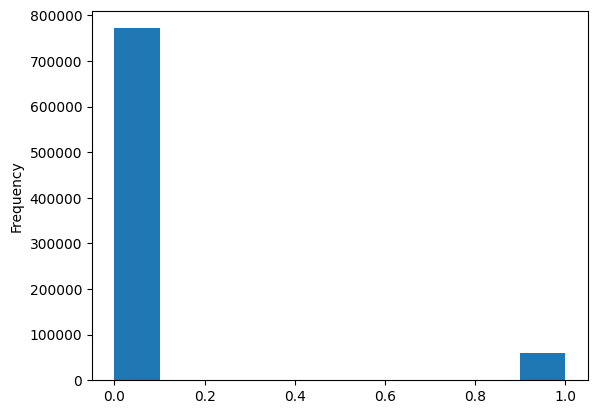

In [14]:
train['target'].plot(kind='hist');

Явный дисбаланс классов, необходимо попробовать оверсемплинг

Посмотрим на id

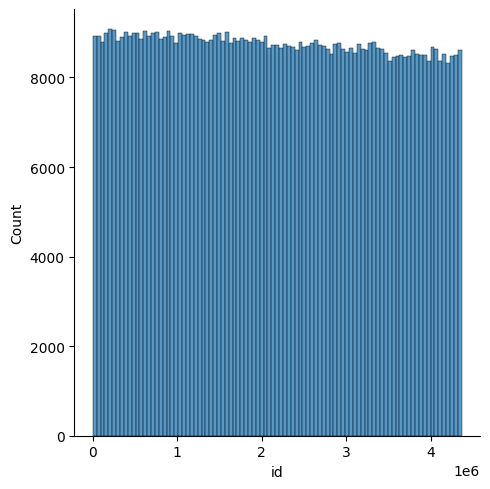

In [15]:
sns.displot(train, x='id')

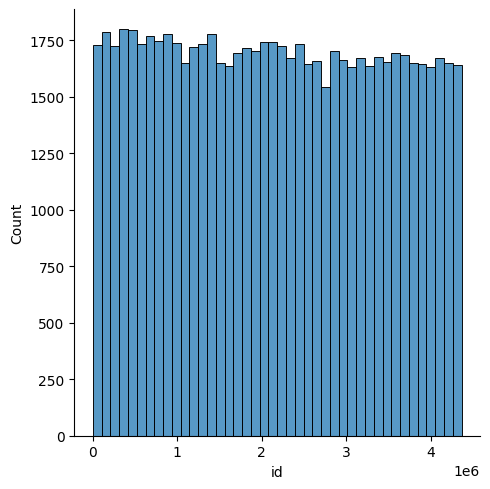

In [16]:
sns.displot(test, x='id')

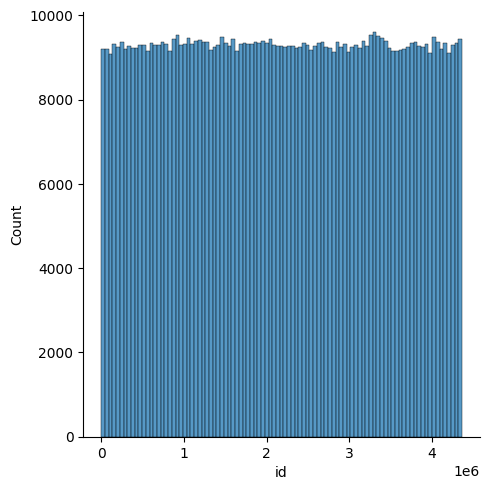

In [17]:
sns.displot(features, x='id')

Есть подозрение, что id на трейне и на тесте повторяются, а в features - нет, поскольку распределение в features ровное, а в train и test - кривое (более старых пользователей больше, чем более новых)

In [18]:
print('Всего строк в датасете train:', train.shape[0], 'Кол-во уникальных:', train['id'].nunique(), 'Мин:', np.min(train['id']), 'Макс:', np.max(train['id']))
print('Всего строк в датасете test:', test.shape[0], 'Кол-во уникальных:', test['id'].nunique(), 'Мин:', np.min(test['id']), 'Макс:', np.max(test['id']))
print('Всего строк в датасете features:', features.shape[0], 'Кол-во уникальных:', features['id'].nunique(), 'Мин:', np.min(features['id']), 'Макс:', np.max(features['id']))

Всего строк в датасете train: 831653 Кол-во уникальных: 806613 Мин: 2 Макс: 4362694
Всего строк в датасете test: 71231 Кол-во уникальных: 70152 Мин: 55 Макс: 4362720
Всего строк в датасете features: 902389 Кол-во уникальных: 872577 Мин: 2 Макс: 4362720


Ага, айдишники повторяются во всех датасетах, надо посмотреть повнимательнее

In [19]:
train.duplicated(subset=['id']).value_counts()

False    806613
True      25040
dtype: int64

In [20]:
test.duplicated(subset=['id']).value_counts()

False    70152
True      1079
dtype: int64

In [21]:
features.duplicated(subset=['id']).value_counts()

False    872577
True      29812
dtype: int64

In [22]:
ids = train["id"]
train[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,vas_id,buy_time,target
14042,342,2.0,2018-11-19,1.0
14041,342,1.0,2018-11-05,0.0
19825,492,6.0,2018-12-17,1.0
19824,492,4.0,2018-10-08,0.0
22908,579,4.0,2018-11-19,1.0
...,...,...,...,...
751154,4339012,2.0,2018-11-19,1.0
248700,4347691,4.0,2018-11-26,0.0
248701,4347691,6.0,2018-11-19,1.0
366175,4350615,2.0,2018-12-10,1.0


In [23]:
ids = train["id"]
train[ids.isin(ids[ids.duplicated()])].sort_values('id').head(10)

,id,vas_id,buy_time,target
14042,342,2.0,2018-11-19,1.0
14041,342,1.0,2018-11-05,0.0
19825,492,6.0,2018-12-17,1.0
19824,492,4.0,2018-10-08,0.0
22908,579,4.0,2018-11-19,1.0
22909,579,6.0,2018-12-31,0.0
23753,610,8.0,2018-08-27,0.0
23754,610,8.0,2018-11-19,1.0
26111,665,6.0,2018-11-26,1.0
26110,665,2.0,2018-12-10,0.0


In [24]:
ids = test["id"]
test[ids.isin(ids[ids.duplicated()])].sort_values('id').head(10)

,id,vas_id,buy_time
552,274,4.0,2019-01-21
551,274,2.0,2019-01-14
10677,4770,4.0,2019-01-14
10676,4770,2.0,2019-01-21
20241,8166,1.0,2019-01-07
20242,8166,6.0,2019-01-21
25062,9775,6.0,2019-01-14
25061,9775,2.0,2019-01-07
40336,15522,2.0,2019-01-07
40337,15522,6.0,2019-01-14


In [25]:
ids = features["id"]
features[ids.isin(ids[ids.duplicated()])].sort_values('id').head(10)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
196663,372,2018-12-17,-96.799971,-143.929112,-109.050786,-174.096798,-114.468246,-195.20179,-16.08618,-65.076097,...,-835.373846,-471.770792,-25.996269,-37.630448,-290.747724,-22.832889,-0.694428,-12.175933,-0.45614,0.0
732941,372,2018-12-10,159.560029,-100.259112,146.889214,-110.936798,141.471754,-132.04179,-16.08618,-65.076097,...,4405.626154,1933.229208,-25.996269,-37.630448,29.252276,-22.832889,-0.694428,-12.175933,-0.45614,0.0
720279,404,2018-10-22,354.550029,164.940888,526.199214,327.583202,520.781754,306.47821,403.40382,354.413903,...,2712.626154,1326.229208,-24.996269,102.369552,201.252276,30.167111,-0.694428,-10.175933,-0.45614,0.0
183022,404,2018-08-06,-78.159971,499.180888,-84.480786,460.553202,-89.898246,439.44821,-16.08618,556.963903,...,-408.373846,-588.770792,-25.996269,-22.630448,861.252276,34.167111,-0.694428,47.824067,-0.45614,0.0
798797,487,2018-11-19,80.230029,77.790888,218.829214,588.753202,213.411754,567.64821,-4.22618,67.963903,...,-933.373846,-613.770792,-24.996269,5.369552,-113.747724,28.167111,0.305572,-12.175933,4.54386,0.0
578318,487,2018-12-10,-28.169971,-30.359112,119.749214,417.873202,114.331754,396.76821,-16.08618,-35.416097,...,-973.373846,-613.770792,-25.996269,-9.630448,11.252276,45.167111,0.305572,-12.175933,2.54386,1.0
656783,620,2018-12-17,-76.899971,-329.349112,-90.840786,-381.956798,-96.258246,-403.06179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
399789,620,2018-09-24,-64.099971,-320.009112,-78.040786,-372.616798,-83.458246,-393.72179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
377059,748,2018-10-29,-89.169971,-385.299112,-103.110786,-437.906798,-108.528246,-459.01179,-16.08618,-65.076097,...,5142.626154,5175.229208,-25.996269,-5.630448,-1.747724,-22.832889,-0.694428,-12.175933,-0.45614,0.0
827717,748,2018-07-16,-96.799971,-126.829112,-110.740786,-179.436798,-116.158246,-200.54179,-16.08618,-65.076097,...,-177.373846,17.229208,-25.996269,-11.630448,-9.747724,-16.832889,-0.694428,-3.175933,-0.45614,1.0


In [26]:
features['id'].value_counts().sort_values(ascending=False)

3549398    2
3353035    2
2926704    2
3221567    2
1253215    2
          ..
2777413    1
2781432    1
2785623    1
2599316    1
3521152    1
Name: id, Length: 872577, dtype: int64

А вот эта информация точно пригодится. Клиентам предлагали услугу (разные услуги) от 1 до 2 раз. Можно смело мержить датасеты с помощью merge_asof nearest - чтобы айдишники совпадали, а из features подтягивалась строчка с ближайшей датой.  

Осталось посмотреть на vas_id

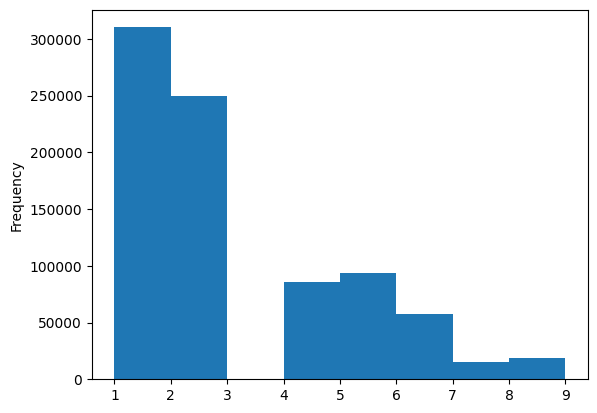

In [27]:
train['vas_id'].plot(kind='hist', bins=8);

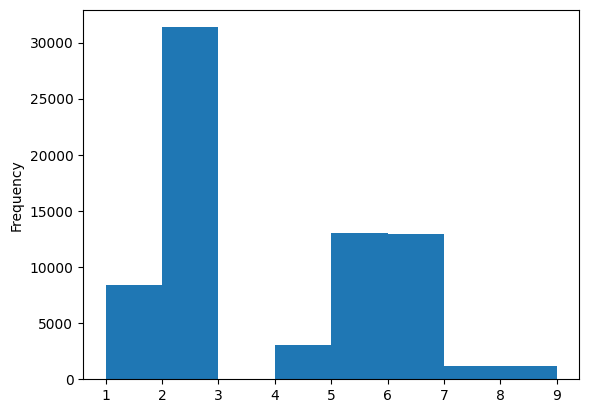

In [28]:
test['vas_id'].plot(kind='hist', bins=8);

Тут напрашиваются 2 вывода:  
    1. Третья услуга непопулярна, её не предлагают (примем к сведению)  
    2. Распределения на трейне и на тесте вообще не совпадают. Печально, но сделать с этим я ничего не могу - других трейнов и тестов у меня просто нет, а оверсемплить тут будет некорректно.  

На всякий случай проверю диапазоны дат.

In [29]:
np.min(train['buy_time']), np.max(train['buy_time'])

(datetime.date(2018, 7, 9), datetime.date(2018, 12, 31))

In [30]:
np.min(test['buy_time']), np.max(test['buy_time'])

(datetime.date(2019, 1, 7), datetime.date(2019, 1, 21))

Трейн - с 9 июля 2018 по 31 декабря 2018.  
Тест - с 7 января 2019 по 21 января 2019.  
Кажется, кто-то слукавил в формулировке задания, не так ли?

#### 3. Объеденение merge_asof nearest

В этот момент в моем колабе кончилась память, и я решил оставить в features только те айди, которые есть в трейне или тесте

In [31]:
unique_ids = set(train["id"]).union(set(test["id"]))
len(unique_ids)

872577

In [32]:
features = features.loc[features["id"].isin(unique_ids), :]

In [33]:
features.shape

(902389, 255)

In [34]:
sys.getsizeof(features)

1901333639

In [35]:
# features.to_csv('./for_course_project/features.csv', sep='\t')

*Я понимаю узкое место этой оптимизации - как же быть, если в тесте придут другие айдишники. На это отвечу - решение не предназначено для прода. Так же, как бустинги, LAMA и уж тем более RNN.*

Теперь собственно сам мердж.

In [36]:
train = pd.read_csv('./for_course_project/data_train.csv').drop(['Unnamed: 0'], axis=1)
train['buy_time'] = train['buy_time'].apply(lambda data: date.fromtimestamp(data)).astype(np.datetime64)
features['buy_time'] = features['buy_time'].astype(np.datetime64)
train = train.sort_values(by=['id'])
features = features.sort_values(by=['id'])
train

,id,vas_id,buy_time,target
116,2,2.0,2018-12-24,0.0
213,4,1.0,2018-08-06,0.0
499,15,1.0,2018-08-13,0.0
513,16,2.0,2018-10-29,0.0
904,29,1.0,2018-08-06,0.0
...,...,...,...,...
830148,4362634,1.0,2018-12-31,0.0
830227,4362640,2.0,2018-12-31,0.0
830311,4362647,6.0,2018-12-31,0.0
831218,4362684,5.0,2018-12-24,0.0


In [37]:
train = pd.merge_asof(train, 
                       features, 
                       on='id', 
                       by='buy_time',
                       direction='nearest')
train

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2,2.0,2018-12-24,0.0,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
1,4,1.0,2018-08-06,0.0,-42.559971,99.460888,-43.780786,72.293202,-49.198246,51.18821,...,-927.373846,-570.770792,-24.996269,-36.630448,-212.747724,-14.832889,-0.694428,-1.175933,-0.45614,1.0
2,15,1.0,2018-08-13,0.0,-96.799971,-336.159112,-110.740786,-329.456798,-116.158246,-350.56179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,16,2.0,2018-10-29,0.0,155.310029,-92.509112,158.309214,-95.126798,152.891754,-116.23179,...,-977.373846,-613.770792,-25.996269,-37.630448,-291.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4,29,1.0,2018-08-06,0.0,-42.559971,99.460888,-43.780786,72.293202,-49.198246,51.18821,...,-927.373846,-570.770792,-24.996269,-36.630448,-212.747724,-14.832889,-0.694428,-1.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,4362634,1.0,2018-12-31,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831649,4362640,2.0,2018-12-31,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831650,4362647,6.0,2018-12-31,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831651,4362684,5.0,2018-12-24,0.0,-34.169971,43.280888,-36.250786,15.233202,-41.668246,-5.87179,...,-365.373846,-29.770792,-23.996269,-37.630448,2719.252276,-20.832889,-0.694428,-12.175933,-0.45614,0.0


In [91]:
test = pd.read_csv('./for_course_project/data_test.csv').drop(['Unnamed: 0'], axis=1)
test['buy_time'] = test['buy_time'].apply(lambda data: date.fromtimestamp(data)).astype(np.datetime64)
test = test.sort_values(by=['id'])
test

,id,vas_id,buy_time
87,55,2.0,2019-01-14
98,64,4.0,2019-01-21
278,151,2.0,2019-01-14
552,274,4.0,2019-01-21
551,274,2.0,2019-01-14
...,...,...,...
69747,4362676,2.0,2019-01-21
69754,4362677,2.0,2019-01-14
70157,4362697,5.0,2019-01-07
70535,4362712,5.0,2019-01-14


In [92]:
test = pd.merge_asof(test, 
                       features, 
                       on='id', 
                       by='buy_time',
                       direction='nearest')
test

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,55,2.0,2019-01-14,-65.299971,71.210888,-75.070786,35.273202,-80.488246,14.16821,-16.08618,...,-551.373846,-209.770792,-24.996269,-37.630448,-133.747724,-20.832889,-0.694428,-12.175933,-0.45614,1.0
1,64,4.0,2019-01-21,152.050029,257.220888,195.609214,267.113202,190.191754,246.00821,-16.08618,...,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
2,151,2.0,2019-01-14,-65.299971,71.210888,-75.070786,35.273202,-80.488246,14.16821,-16.08618,...,-551.373846,-209.770792,-24.996269,-37.630448,-133.747724,-20.832889,-0.694428,-12.175933,-0.45614,1.0
3,274,4.0,2019-01-21,152.050029,257.220888,195.609214,267.113202,190.191754,246.00821,-16.08618,...,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
4,274,2.0,2019-01-14,-65.299971,71.210888,-75.070786,35.273202,-80.488246,14.16821,-16.08618,...,-551.373846,-209.770792,-24.996269,-37.630448,-133.747724,-20.832889,-0.694428,-12.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71226,4362676,2.0,2019-01-21,-96.799971,177.650888,-110.740786,140.043202,-116.158246,118.93821,-16.08618,...,-968.373846,-611.770792,-11.996269,-31.630448,-162.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
71227,4362677,2.0,2019-01-14,18.620029,-84.169112,18.159214,-82.216798,12.741754,-103.32179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
71228,4362697,5.0,2019-01-07,-56.299971,-54.149112,-66.070786,-102.586798,-71.488246,-123.69179,-16.08618,...,-887.373846,-607.770792,-25.996269,-35.630448,-239.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
71229,4362712,5.0,2019-01-14,18.620029,-84.169112,18.159214,-82.216798,12.741754,-103.32179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


#### 4. Вспомогательные функции

In [38]:
def f1_metric(y_true, y_pred):
    return f1_score(y_true, (y_pred > 0.5).astype(int))

In [39]:
def acc_score(y_true, y_pred):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int))

In [40]:
def f1_score_macro(true, pred):
    return f1_score(true, pred.astype(int), average='macro')

In [41]:
def f1_score_macro_threshold(true, pred, threshold=0.3):
    return f1_score(true, np.where(pred > threshold, 1, 0), average='macro')

In [42]:
def standart_scale(df, exclude_cols):
    target_cols = list(set(df.columns) - set(exclude_cols))
    scaler = StandardScaler()
    df[target_cols] = scaler.fit_transform(df[target_cols])    
    return df

In [43]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("*"*42)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [44]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

#### 5. Бейзлайн - DesicionTreeClassifier

Тут можно было бы выбрать логрег, но дерево требует меньше предобработки, и потому отправляется в бейзлайн.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
     train.drop(['target', 'buy_time'], axis=1),
     train['target'], test_size=0.25, shuffle=True,random_state=42)


print("X_train.shape = {} rows, {} cols".format(*X_train.shape))
print("X_test.shape = {} rows, {} cols".format(*X_test.shape))

X_train.shape = 623739 rows, 255 cols
X_test.shape = 207914 rows, 255 cols


In [46]:
model = DecisionTreeClassifier(min_samples_leaf=3, max_depth=25, class_weight='balanced')

model.fit(X_train, y_train)
train_preds = model.predict(X_train)
valid_preds = model.predict(X_test)

In [47]:
train_score = f1_score(y_train, train_preds, average='macro')
test_score = f1_score(y_test, valid_preds, average='macro')

print(f"Train-score: {round(train_score, 4)}, Test-score: {round(test_score, 4)}")

Train-score: 0.7458, Test-score: 0.681


Роскошные метрики и никакого переобучения. Давайте ещё полюбуемся:

<Axes: >

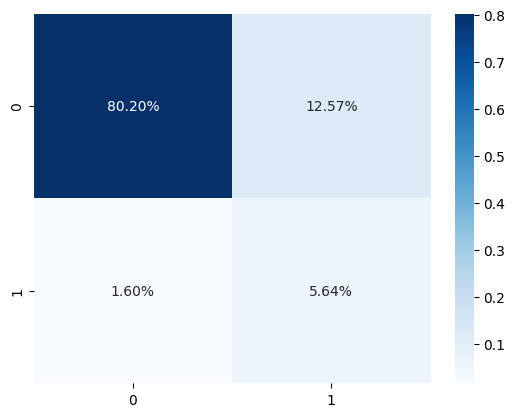

In [48]:
sns.heatmap(confusion_matrix(y_test, valid_preds)/np.sum(confusion_matrix(y_test, valid_preds)), 
            fmt='.2%', cmap='Blues', annot=True)

#### 6. Более продвинутое решение - бустинги

Сразу же исправлю дисбаланс классов. Заодно выполню стандартизацию.

In [49]:
train_balanced = balance_df_by_target(train, target_name='target', method='over')
exclude_cols = ['id', 'vas_id', 'buy_time', 'target']
train_balanced = standart_scale(train_balanced, exclude_cols=exclude_cols)
train_balanced.target.value_counts(normalize=True)

0.0    0.516481
1.0    0.483519
Name: target, dtype: float64

Сначала попробую XGBoost - задачка вполне каггловская, а на каггле он давал мне неплохие результаты

In [50]:
cv_strategy = KFold(n_splits=10)
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "seed": 42,
        'use_label_encoder': False
    }
model = xgboost.XGBClassifier(**params)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train.drop(['target', 'buy_time'], axis=1), 
    train['target'],
    model, 
    metric=f1_score_macro, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 748487, valid-observations = 83166
train-score = 0.6481, valid-score = 0.675
******************************************
Fold: 2, train-observations = 748487, valid-observations = 83166
train-score = 0.6489, valid-score = 0.6501
******************************************
Fold: 3, train-observations = 748487, valid-observations = 83166
train-score = 0.6492, valid-score = 0.6499
******************************************
Fold: 4, train-observations = 748488, valid-observations = 83165
train-score = 0.6506, valid-score = 0.6198
******************************************
Fold: 5, train-observations = 748488, valid-observations = 83165
train-score = 0.6549, valid-score = 0.603
******************************************
Fold: 6, train-observations = 748488, valid-observations = 83165
train-score = 0.6541, valid-score = 0.5761
******************************************
Fold: 7, train-observations = 748488, valid-observations = 83165
train-score = 0.6577, valid-sco

Не впечатляет, правда? А теперь попробую с балансировкой:

In [51]:
# К сожалению, слишком долго для моих текущих мощностей
# cv_strategy2 = KFold(n_splits=7)
# params2 = {
#         "objective": "binary:logistic",
#         "booster" : "gbtree",
#         "eval_metric": "auc",
#         "learning_rate": 0.02,
#         "max_depth": 20,
#         "seed": 42,
#         'use_label_encoder': False
#     }

# model2 = xgboost.XGBClassifier(**params2)

# estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
#     train_balanced.drop(['target', 'buy_time'], axis=1), 
#     train_balanced['target'],
#     model2, 
#     metric=f1_score_macro, 
#     cv_strategy=cv_strategy2
# )

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
     train_balanced.drop(['target', 'buy_time'], axis=1),
     train_balanced['target'], test_size=0.25, shuffle=True,random_state=42)


print("X_train.shape = {} rows, {} cols".format(*X_train.shape))
print("X_test.shape = {} rows, {} cols".format(*X_test.shape))

X_train.shape = 1120274 rows, 255 cols
X_test.shape = 373425 rows, 255 cols


In [53]:
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "learning_rate": 0.02,
        "max_depth": 20,
        "seed": 42,
        'use_label_encoder': False
    }

model = xgboost.XGBClassifier(**params)

model.fit(X_train, y_train.astype(int))

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [54]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_score = f1_score(y_train, train_pred, average='macro')
test_score = f1_score(y_test, test_pred, average='macro')

print(f"Train-score: {round(train_score, 4)}, Test-score: {round(test_score, 4)}")

Train-score: 0.9439, Test-score: 0.9289


Метрики - просто заглядение. Можно ради интереса попробовать свёртки.

#### 7. CNN

In [76]:
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(255, 1)))
model.add(MaxPool1D(pool_size=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPool1D(pool_size=2, padding='same'))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPool1D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 253, 32)           128       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 125, 64)           6208      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 63, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 61, 128)           24704     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 31, 128)        

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
     train_balanced.drop(['target', 'buy_time'], axis=1),
     train_balanced['target'], test_size=0.25, shuffle=True,random_state=42)

early_stop = callbacks.EarlyStopping(monitor='loss',
                                     min_delta=0,
                                     patience=5,
                                     verbose=1,
                                     mode='auto',
                                     baseline=0.006,
                                     restore_best_weights=False)

In [81]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, steps_per_epoch=100, batch_size=128, callbacks=[early_stop])

Epoch 1/10
100/100 [==============================] - 51s 513ms/step - loss: 0.6924 - accuracy: 0.5195 - val_loss: 0.6927 - val_accuracy: 0.5162
Epoch 2/10
100/100 [==============================] - 53s 534ms/step - loss: 0.6925 - accuracy: 0.5180 - val_loss: 0.6926 - val_accuracy: 0.5162
Epoch 3/10
100/100 [==============================] - 52s 525ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6926 - val_accuracy: 0.5162
Epoch 4/10
100/100 [==============================] - 51s 510ms/step - loss: 0.6918 - accuracy: 0.5280 - val_loss: 0.6926 - val_accuracy: 0.5162
Epoch 5/10
100/100 [==============================] - 54s 542ms/step - loss: 0.6928 - accuracy: 0.5135 - val_loss: 0.6926 - val_accuracy: 0.5162
Epoch 5: early stopping


In [83]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

11670/11670 [==============================] - 55s 5ms/step


In [85]:
train_pred = (train_pred > 0.5).astype(int)
test_pred = (test_pred > 0.5).astype(int)

In [86]:
train_score = f1_score(y_train, train_pred, average='macro')
test_score = f1_score(y_test, test_pred, average='macro')

print(f"Train-score: {round(train_score, 4)}, Test-score: {round(test_score, 4)}")

Train-score: 0.3406, Test-score: 0.3404


#### 8. Результаты, выводы

Предсказуемо, лучший вариант показал бустинг с предварительным оверсемплингом (Train-score: 0.9439, Test-score: 0.9289)  
Неплохое приближение дает бейзлайн - дерево решений. Оно, конечно, слишком простое для таких сложных данных, но справляется неплохо без необходимости предобрабатывать данные.  

###### Что я еще пробовал из того, что не вошло в финальное решение:

1. Библиотеку autoEDA - не дала мне нужного представления о данных
2. Фреймворк LightAutoML (LAMA) - выступил хуже XGBoost
3. Полноценную кросс-валидацию - слишком долго на моих мощностях, а учитывая, что наверняка придется менять гиперпараметры - совсем нереалистично по времени. Заготовку для нее оставил, если появится доступ к мощностям - запущу
4. Стэкинг - выступил хуже XGBoost
5. Другие методы мержа датасетов (кроме nearest, можно еще forward и backward) - не очень влияет на метрику
6. Другие методы работы с дисбалансом классов (например, SMOTE и tomek) - метрика чуть ухудшилась

###### Что, вероятно, от меня ожидалось, из того, что я не попробовал использовать:

1. Фреймворк Luigi - тут он просто не нужен
2. Feature engineering (например, нагенерить категориальных признаков из вещественных, или нагенерить час и день из таймстемпа) - аналогично, они не нужны. Скорее, тут есть лишние признаки, с чем отлично справляются механизмы регуляризации в продвинутых моделях.

#### 9. Обучение модели на всем датасете и сохранение прогноза

In [89]:
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "learning_rate": 0.02,
        "max_depth": 20,
        "seed": 42,
        'use_label_encoder': False
    }

model = xgboost.XGBClassifier(**params)

model.fit(train_balanced.drop(['target', 'buy_time'], axis=1),
          train_balanced['target']
         )

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [95]:
train_pred = model.predict(train_balanced.drop(['target', 'buy_time'], axis=1))
test_pred = model.predict(test.drop(['buy_time'], axis=1))
train_score = f1_score(train_balanced.target, train_pred, average='macro')

print(f"Train-score: {round(train_score, 4)}")

Train-score: 0.9427


In [121]:
test_pred_proba = model.predict_proba(test.drop(['buy_time'], axis=1))

Прекрасно, теперь сохраним модель в формат pickle.

In [98]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [99]:
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)
model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

И сохранить прогнозы в формате csv

In [123]:
test_preds = pd.DataFrame(test[['id', 'vas_id', 'buy_time']].copy())
test_preds['prediction'] = test_pred_proba[:,1]
test_preds

,id,vas_id,buy_time,prediction
0,55,2.0,2019-01-14,0.205718
1,64,4.0,2019-01-21,0.116356
2,151,2.0,2019-01-14,0.205718
3,274,4.0,2019-01-21,0.116356
4,274,2.0,2019-01-14,0.205718
...,...,...,...,...
71226,4362676,2.0,2019-01-21,0.096242
71227,4362677,2.0,2019-01-14,0.067269
71228,4362697,5.0,2019-01-07,0.134433
71229,4362712,5.0,2019-01-14,0.067310


In [124]:
test_preds.to_csv('answers_test.csv', index=False)

#### 10. Бонус: рекомендации

Дело в том, что с помощью этой же модели с помощью этой же модели можно порекомендовать услугу, наиболее вероятную для подключения. Это довольно просто:

In [100]:
offer = pd.DataFrame(test.drop(['buy_time'], axis=1))
model.predict_proba(offer)[:,1]

array([0.20571794, 0.1163564 , 0.20571794, ..., 0.1344327 , 0.06730955,
       0.15927997], dtype=float32)

In [114]:
offer_predict = pd.DataFrame(test['id'].copy())

for i in [1, 2, 4, 5, 6, 7, 8, 9]:
    offer = pd.DataFrame(test['id'].copy())
    offer['vas_id'] = i
    offer = pd.merge_asof(offer, 
                          test.drop(['buy_time', 'vas_id'], axis=1),
                          on='id'
                         )
    offer_predict[i] = model.predict_proba(offer)[:,1]
offer_predict['max prob offer'] = offer_predict.iloc[:, 1:-1].max(axis = 1)
offer_predict['vas_id offer'] = offer_predict.iloc[:, 1:-1].idxmax(axis = 1)
offer_predict

,id,1,2,4,5,6,7,8,9,max prob offer,vas_id offer
0,55,0.194861,0.205718,0.201496,0.229746,0.304093,0.525752,0.321436,0.180318,0.525752,7
1,64,0.067269,0.067269,0.116356,0.067310,0.074701,0.067825,0.067825,0.460497,0.116356,9
2,151,0.194861,0.205718,0.201496,0.229746,0.304093,0.525752,0.321436,0.180318,0.525752,7
3,274,0.194861,0.205718,0.201496,0.229746,0.304093,0.525752,0.321436,0.180318,0.525752,7
4,274,0.194861,0.205718,0.201496,0.229746,0.304093,0.525752,0.321436,0.180318,0.525752,7
...,...,...,...,...,...,...,...,...,...,...,...
71226,4362676,0.096242,0.096242,0.150688,0.116922,0.154531,0.148964,0.104518,0.127516,0.154531,6
71227,4362677,0.067269,0.067269,0.137729,0.067310,0.184599,0.067825,0.067825,0.469733,0.184599,9
71228,4362697,0.159280,0.159280,0.323112,0.134433,0.326533,0.186313,0.184304,0.210727,0.326533,6
71229,4362712,0.067269,0.067269,0.137729,0.067310,0.184599,0.067825,0.067825,0.469733,0.184599,9


Можно посмотреть, какие именно услуги мы хотим подключать абонентам:

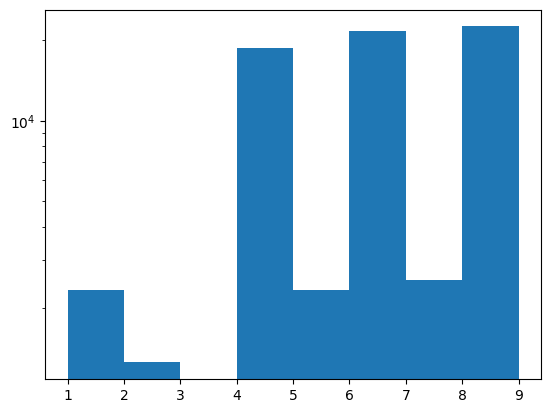

In [128]:
plt.hist(offer_predict['vas_id offer'], log=True, bins=8);

Еще можно посмотреть распределение вероятностей подключения самых топовых услуг:

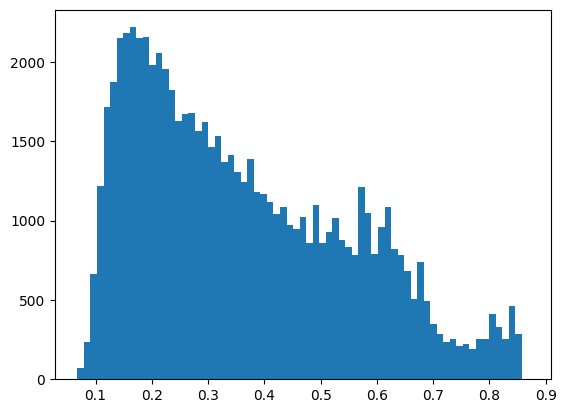

In [127]:
plt.hist(offer_predict['max prob offer'], bins=69);

#### 10.1 Выводы по рекомендациям:

Любопытно, что распределение кардинально отличается от базового распределения в тестовом датасете. Возможно, стоит попробовать внести изменения в существующую (да, я понимаю, что скорее **существовавшую**, курс то 2019 года) рекомендательную систему после тщательного анализа уже не ml, а бизнес-метрик.  

Кроме того, возможно, стоит выдавать рекомендации только пользователям с вероятностью подключения топовой услуги начиная с определенного трешхолда. Это напоминает задачу аплифт-моделирования - можно разделить пользователей на группы:  
1. Пользователи, которые совершат нужное действие независимо от коммуникации
2. Те, кто совершат действие, если будет коммуникация
3. Те, кто не совершит действие независимо от коммуникации
4. Не совершат действие, если коммуникация будет

И наша задача - не беспокоить пользователей из 4 группы. Это отдельная задача, в которой могут быть использованы результаты моей работы.